In [1]:
import pickle  
import os
import glob
import imgaug as aug 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa 
from PIL import Image
from pathlib import Path
from skimage.io import imread
import cv2
import zipfile
color = sns.color_palette()

In [2]:
#Unzipping The Zip File to Load The data
local_zip = 'chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
data_dir = Path('/tmp/chest_xray')
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

normal_cases_dir = train_dir/'NORMAL'
pneumonia_cases_dir = train_dir/'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for img in normal_cases:
    train_data.append((img,0))
for img in pneumonia_cases:
    train_data.append((img,1))

train_data = pd.DataFrame(train_data, columns=['Image','Label'], index = None)

train_data = train_data.sample(frac = 1.).reset_index(drop = True)
train_data.head()

,Image,Label
0,/tmp/chest_xray/train/NORMAL/IM-0295-0001.jpeg,0
1,/tmp/chest_xray/train/PNEUMONIA/person1177_vir...,1
2,/tmp/chest_xray/train/PNEUMONIA/person1177_bac...,1
3,/tmp/chest_xray/train/PNEUMONIA/person95_virus...,1
4,/tmp/chest_xray/train/PNEUMONIA/person465_bact...,1


1    3875
0    1341
Name: Label, dtype: int64


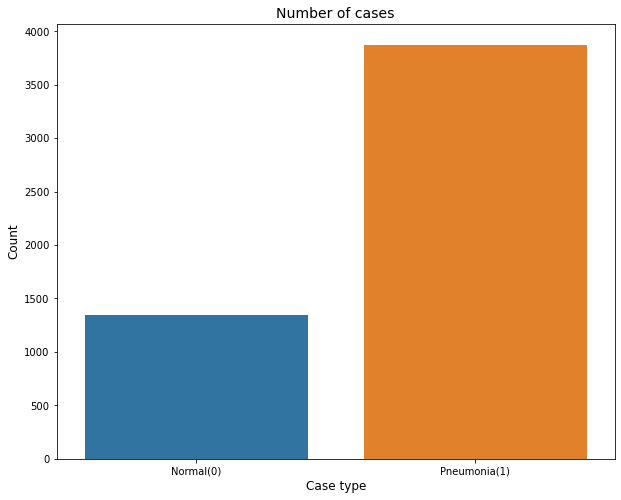

In [4]:
#Visualizing the Imbalance in the dataset
cases_count = train_data['Label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

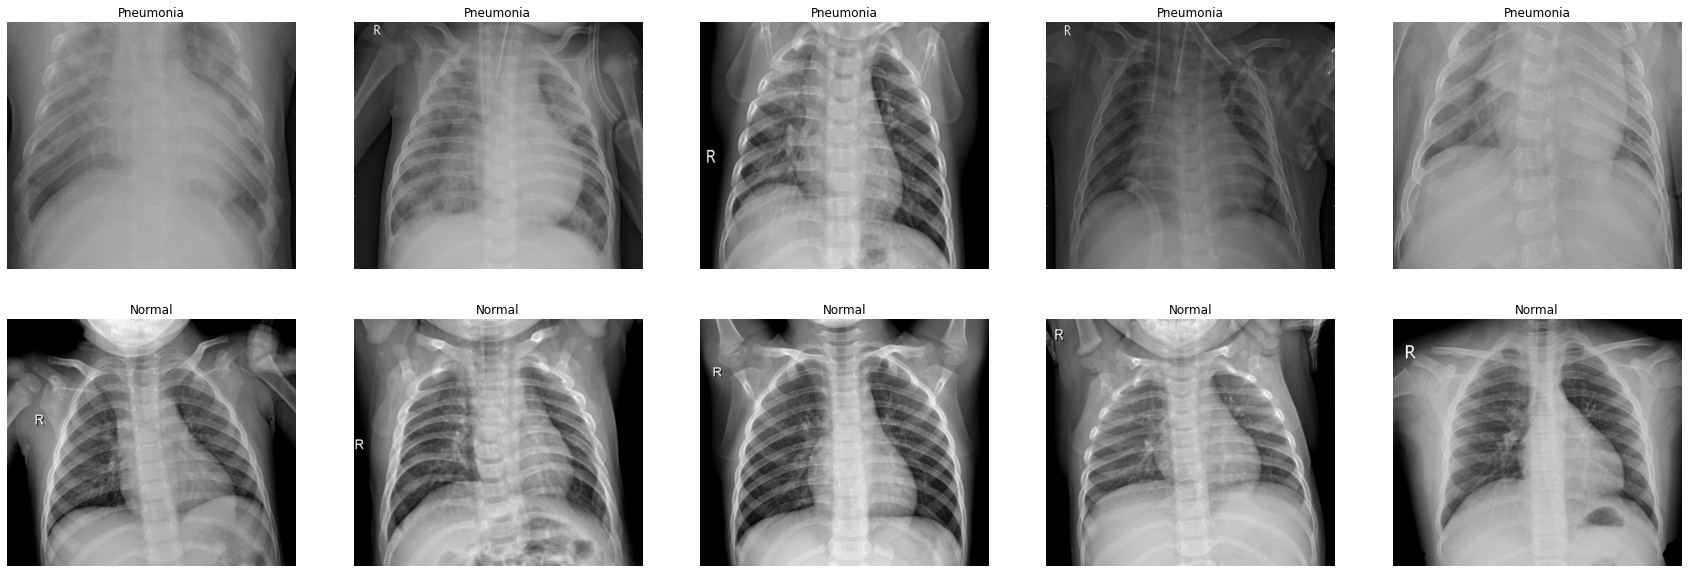

In [5]:
#Visualizing the X Ray Images

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['Label']==1]['Image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['Label']==0]['Image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [12]:
#Augmentation Sequence to solve the imbalance in the data
IMG_SIZE = 200
seq = iaa.OneOf([
        iaa.Fliplr(),
        iaa.Multiply((1.2 , 1.5)),
        iaa.Add((-10, 10), per_channel=0.5)        
])

n= len(train_data)
indicies = np.arange(n)
np.random.shuffle(indicies)
train_images = []
train_labels = []
augmented_images = []
for idx in indicies:
    img_name = train_data.iloc[idx]['Image']
    label = train_data.iloc[idx]['Label'] 
    img = cv2.imread(str(img_name))
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
   
    if img.shape[2]==1:
        img = np.dstack([img,img,img])
    orig_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    orig_img = img.astype(np.float32)/255

    if label == 0:
        aug_img1 = seq.augment_image(img)
        aug_img2 = seq.augment_image(img)
        aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
        aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
        aug_img1 = aug_img1.astype(np.float32)/255.
        aug_img2 = aug_img2.astype(np.float32)/255.
        augmented_images.append([orig_img,aug_img1,aug_img2])
        train_images.append(orig_img)
        train_images.append(aug_img1)
        train_images.append(aug_img2)
        train_labels.append(label)
        train_labels.append(label)
        train_labels.append(label)
    else:
        train_images.append(orig_img)
        train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)
augmented_images = np.array(augmented_images)
print(train_images.shape)
print(train_labels.shape)
print(augmented_images.shape)

(7898, 200, 200, 3)
(7898,)
(1341, 3, 200, 200, 3)


<Figure size 432x288 with 0 Axes>

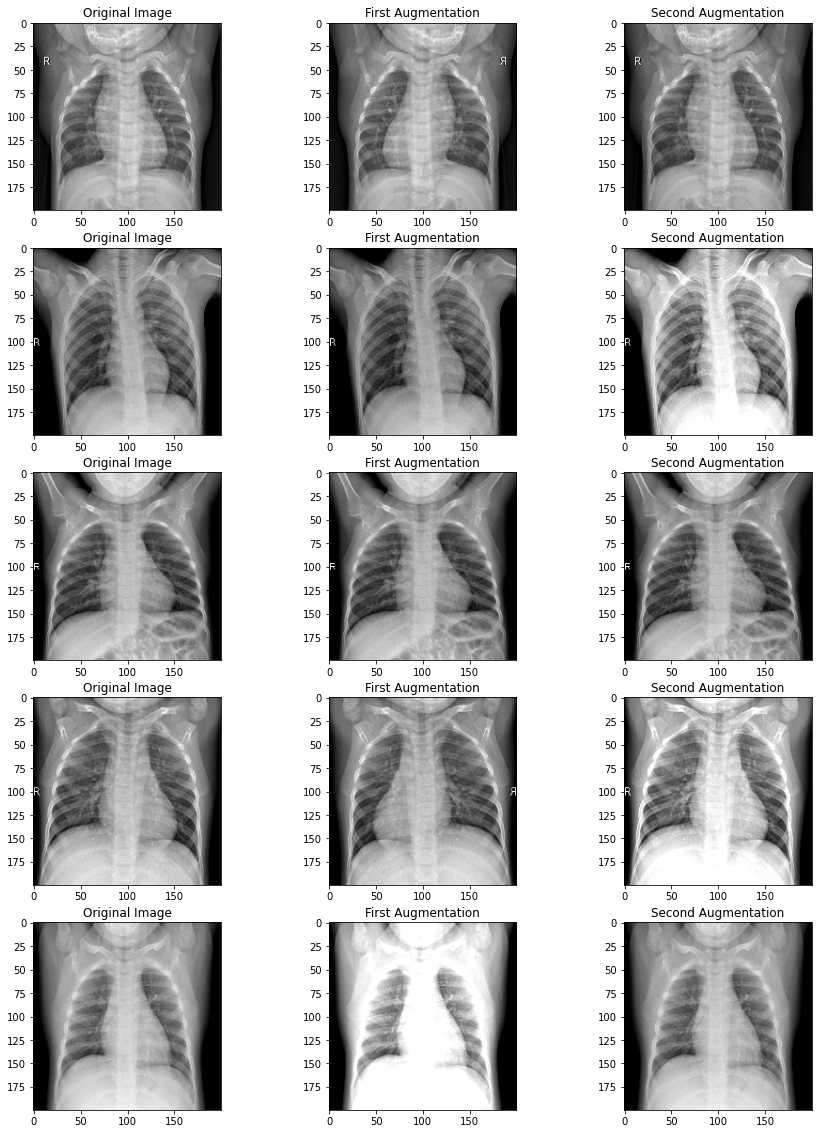

In [13]:
#Visualizing The Augmentations
plt.figure()
f, ax = plt.subplots(5,3,figsize=(15,20))
j = 0
for i in range(15):
    ax[i//3, i%3].imshow(augmented_images[i//3][j])
    if j==0:
        ax[i//3, i%3].set_title("Original Image") #Original Image in the Dataset
        j+=1
    elif j==1:
        ax[i//3,i%3].set_title("First Augmentation") #First Augmentation of Image
        j+=1
    elif j==2:
        ax[i//3,i%3].set_title("Second Augmentation") #Second Augmentation of Image
        j=0

In [14]:
#Saving the Augmented data
pickle_out = open("X_200.pickle","wb")
pickle.dump(train_images,pickle_out)
pickle_out.close()

pickle_out = open("y_200.pickle","wb")
pickle.dump(train_labels,pickle_out)
pickle_out.close()